In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense, Conv2DTranspose, Flatten, LeakyReLU, Reshape
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Sequential
import os
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from skimage import exposure
from IPython.display import clear_output

In [2]:
"""
Linux Paths for CheXpert Dataset

train_dir = os.path.abspath("/media/nicholasjprimiano/8A5C72285C720F67/ML_C/CheXpert/CheXpert-Keras-master/data/default_split/CheXpert-v1.0-small/CheXpert-v1.0-small/train.csv")
traindf=pd.read_csv(train_dir, dtype=str)

valid_dir = os.path.abspath("/media/nicholasjprimiano/8A5C72285C720F67/ML_C/CheXpert/CheXpert-Keras-master/data/default_split/CheXpert-v1.0-small/CheXpert-v1.0-small/valid.csv")
validdf=pd.read_csv(valid_dir, dtype=str)

for i in range(len(traindf)):
    traindf.iloc[i,0] = "/media/nicholasjprimiano/8A5C72285C720F67/ML_C/CheXpert/CheXpert-Keras-master/data/default_split/CheXpert-v1.0-small/" + traindf.iloc[i,0]"""
    
#Windows Paths for CheXpert Dataset
train_dir = os.path.abspath(r"C:/ML_C/CheXpert/CheXpert-Keras-master/data/default_split/CheXpert-v1.0-small/CheXpert-v1.0-small/train.csv")
traindf=pd.read_csv(train_dir, dtype=str)

#Modify dataframe path
for i in range(len(traindf)):
    traindf.iloc[i,0] = r"C:/ML_C/CheXpert/CheXpert-Keras-master/data/default_split/CheXpert-v1.0-small/" + traindf.iloc[i,0]

#valid_dir = os.path.abspath(r"C:/ML_C/CheXpert/CheXpert-Keras-master/data/default_split/CheXpert-v1.0-small/CheXpert-v1.0-small/valid.csv")
#validdf=pd.read_csv(valid_dir, dtype=str)

In [3]:
#Only looking at AP (anterior-posterior) view xrays
aptrainlist = []
for i in range(len(traindf)):
    if (traindf.iloc[i,4] == "AP"):
        aptrainlist.append(traindf.iloc[i,:])

aptraindf = pd.DataFrame(aptrainlist)

#Only looking at xrays labeled Pneumothorax
paths = []
#for i in range(len(aptraindf[aptraindf["Pneumothorax"] == "1.0"]["Path"])):
#    paths.append(aptraindf[aptraindf["Pneumothorax"] == "1.0"]["Path"].iloc[i])

for i in range(len(aptraindf["Path"])//10):
    paths.append(aptraindf["Path"].iloc[i])

In [4]:
aptraindf.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,C:/ML_C/CheXpert/CheXpert-Keras-master/data/de...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,C:/ML_C/CheXpert/CheXpert-Keras-master/data/de...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,C:/ML_C/CheXpert/CheXpert-Keras-master/data/de...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,C:/ML_C/CheXpert/CheXpert-Keras-master/data/de...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
9,C:/ML_C/CheXpert/CheXpert-Keras-master/data/de...,Male,33,Frontal,AP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


In [5]:
#Normalization called in get_imgs() not used right now
def normalize_xray(img):
    hist_normal = exposure.equalize_adapthist(img/np.max(img))   
    #clache_hist_normal = exposure.equalize_adapthist(hist_normal /np.max(hist_normal))
    #return clache_hist_normal
    return hist_normal

In [6]:
#load 128x128 images

IMG_SIZE = 256
def get_imgs(paths):
    images = []
    for i in paths:
        #Normalized
        images.append(normalize_xray(cv2.cvtColor(cv2.resize(cv2.imread(i),(IMG_SIZE,IMG_SIZE)), cv2.COLOR_BGR2GRAY)))
        #Gray Scale 
        #images.append(cv2.cvtColor(cv2.resize(cv2.imread(i),(IMG_SIZE,IMG_SIZE)), cv2.COLOR_BGR2GRAY))
    return images 

In [7]:
#X_train array of images with values between 0 and 1
X_train = np.array(get_imgs(paths)).astype(np.float32)

In [8]:
#reshaped X train and shifted pixel values between -1 and 1 for tanh
X_train_dcgan = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1) * 2. - 1.

In [9]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([

    keras.layers.Dense(256 * 32 * 32, activation="relu", input_shape=[codings_size]),
    keras.layers.Reshape((32, 32, 256)),
    keras.layers.UpSampling2D(),
    keras.layers.Conv2D(128, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(momentum=0.8),
    keras.layers.Activation("relu"),
    keras.layers.UpSampling2D(),
    keras.layers.Conv2D(64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(momentum=0.8),
    keras.layers.Activation("relu"),
    keras.layers.UpSampling2D(),
    keras.layers.Conv2D(1, kernel_size=3, padding="same"),
    keras.layers.Activation("tanh")

])
generator.summary()

discriminator = keras.models.Sequential([
    
    keras.layers.Conv2D(32, kernel_size=3, strides=2, input_shape=[256, 256, 1], padding="same"),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="same"),
    keras.layers.ZeroPadding2D(padding=((0,1),(0,1))),
    keras.layers.BatchNormalization(momentum=0.8),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(128, kernel_size=3, strides=2, padding="same"),
    BatchNormalization(momentum=0.8),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(256, kernel_size=3, strides=1, padding="same"),
    keras.layers.BatchNormalization(momentum=0.8),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 262144)            26476544  
                                                                 
 reshape (Reshape)           (None, 32, 32, 256)       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 64, 64, 256)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 128)       295040    
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 128)      512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64, 64, 128)       0

In [10]:
gan = keras.models.Sequential([generator, discriminator])

In [11]:
def label_smoothing(y_true,y_pred):
     return tf.keras.losses.binary_crossentropy(y_true,y_pred, label_smoothing=0.2)

In [12]:
discriminator.compile(loss=label_smoothing, optimizer=tf.keras.optimizers.Adam(learning_rate= 0.0002, beta_1 = 0.5, beta_2 = 0.8))
discriminator.trainable = False

gan.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate= 0.0002, beta_1 = 0.5, beta_2 = 0.999))

#changed from 128 - smaller batches seem to yield better results
batch_size = 8
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(250)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [13]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=500):
    generator, discriminator = gan.layers
    
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))   
           
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)

            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X_fake_and_real, y1)

            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            g_loss = gan.train_on_batch(noise, y2)
            
        if epoch % 10 == 0:
            clear_output(wait=True)

        print("g_loss", g_loss)  
        print("d_loss", d_loss) 
        
        plt.imshow(generator(noise)[0,:,:,:] + 1, cmap="gray")
        #print(str(generator(noise)[0,:,:,:]))
        plt.show()


g_loss 0.49401402473449707
d_loss 0.3944985866546631


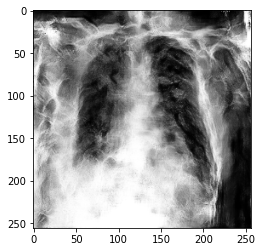

Epoch 12/500
g_loss 5.235382080078125
d_loss 0.4065849184989929


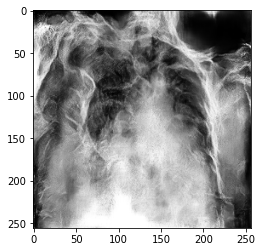

Epoch 13/500
g_loss 2.980767250061035
d_loss 0.46567413210868835


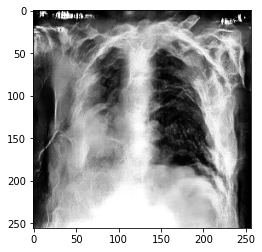

Epoch 14/500
g_loss 0.7162272930145264
d_loss 0.42939403653144836


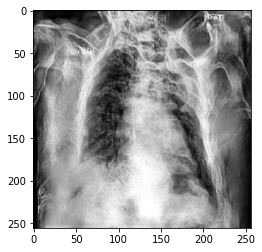

Epoch 15/500
g_loss 1.6786465644836426
d_loss 0.37537574768066406


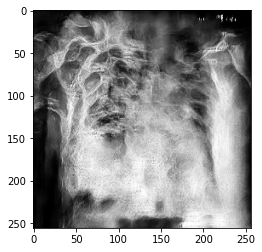

Epoch 16/500
g_loss 2.056102752685547
d_loss 0.5219971537590027


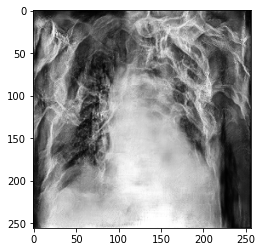

Epoch 17/500


In [ ]:
train_gan(gan, dataset, batch_size, codings_size)